In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
from matplotlib.table import Table


In [3]:
# 1. Initial Data Exploration and Segment Profiling
# -------------------------------------------------
import importlib
import behavioral_profiling as profil  # Assuming segment.py is in the same folder
importlib.reload(profil)

df = pd.read_csv('/Users/cindy/Desktop/DSA3101-Project-3/Data/digital_marketing_campaign_dataset.csv')

df = behavioral_data_processing(df)


{0: {'segment_id': 0, 'size': {'count': 748, 'percentage': '9.3%'}, 'top_features': [{'feature': 'EmailClicks', 'deviation': 7.972341962891094, 'direction': 'higher'}, {'feature': 'PreviousPurchases', 'deviation': 5.032436663115904, 'direction': 'higher'}, {'feature': 'TimeOnSite', 'deviation': 4.207987012137913, 'direction': 'higher'}, {'feature': 'ConversionRate', 'deviation': 3.7265198203581926, 'direction': 'higher'}, {'feature': 'LoyaltyPoints', 'deviation': 3.6446772170591912, 'direction': 'higher'}], 'engagement_patterns': {'website_visits': '24.4', 'pages_per_visit': '5.6', 'time_on_site': '8.1 min', 'email_ctr': '50.3%', 'engagement_depth': '45.1', 'social_propensity': '2.07'}, 'value_metrics': {'conversion_rate': '100.0%', 'previous_purchases': '4.7', 'loyalty_points': '2581'}, 'channel_preferences': {'best_channel': 'Email', 'best_channel_conversion': '100.0%', 'distribution': {'PPC': 22.32620320855615, 'Referral': 21.92513368983957, 'Email': 19.919786096256683, 'Social Medi

NameError: name 'pd' is not defined


Segment sizes:
Cluster_Label
0     857
1     522
2    3053
3    2304
4    1264
Name: count, dtype: int64


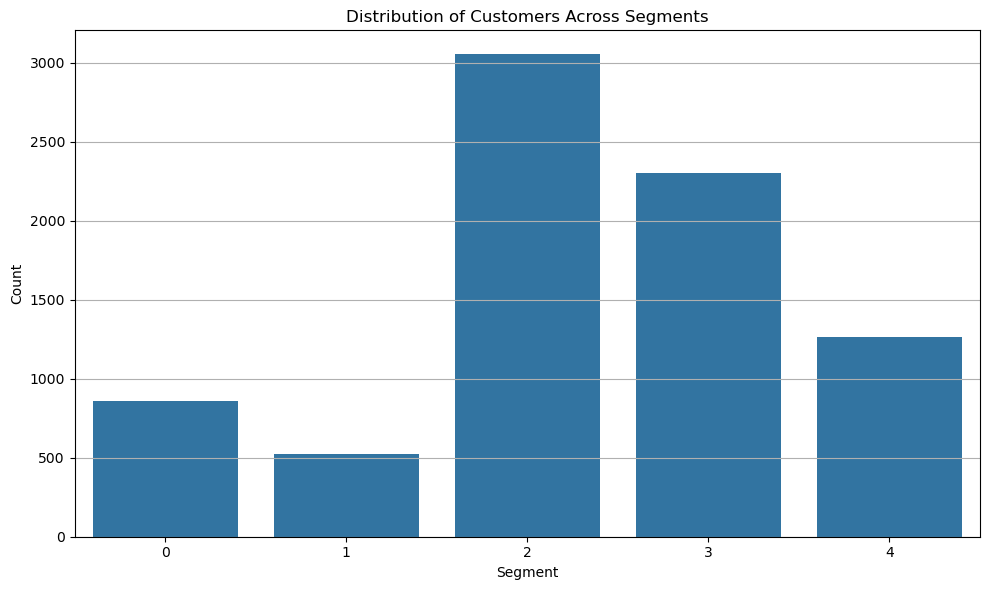

In [10]:
# Basic segment profile
segment_sizes = df['Cluster_Label'].value_counts().sort_index()
print("\nSegment sizes:")
print(segment_sizes)

# Visualize segment distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Cluster_Label', data=df)
plt.title('Distribution of Customers Across Segments')
plt.xlabel('Segment')
plt.ylabel('Count')
plt.grid(axis='y')
plt.tight_layout()
# plt.show()

In [6]:

# Define key behavioral metrics to analyze
digital_metrics = ['WebsiteVisits', 'PagesPerVisit', 'TimeOnSite', 'SocialShares', 'EmailOpens', 'EmailClicks']
transaction_metrics = ['PreviousPurchases', 'LoyaltyPoints']
campaign_metrics = ['ClickThroughRate', 'ConversionRate', 'AdSpend']
all_metrics = digital_metrics + transaction_metrics + campaign_metrics

# Calculate segment profiles with key metrics
segment_profiles = {}
segments = sorted(df['Cluster_Label'].unique())

for segment in segments:
    # Filter data for this segment
    segment_data = df[df['Cluster_Label'] == segment]
    segment_size = len(segment_data)
    
    # Initialize profile object
    segment_profiles[segment] = {
        'size': segment_size,
        'size_percentage': segment_size / len(df) * 100,
        'digital_engagement': {},
        'transaction_history': {},
        'campaign_performance': {},
        'channel_preferences': {},
        'campaign_type_preferences': {}
    }
    
    # Digital engagement metrics
    for metric in digital_metrics:
        segment_profiles[segment]['digital_engagement'][metric] = segment_data[metric].mean()
    
    # Transaction history
    for metric in transaction_metrics:
        segment_profiles[segment]['transaction_history'][metric] = segment_data[metric].mean()
    
    # Campaign performance
    for metric in campaign_metrics:
        segment_profiles[segment]['campaign_performance'][metric] = segment_data[metric].mean()
    
    # Conversion rate
    segment_profiles[segment]['campaign_performance']['conversion_count'] = segment_data['Conversion'].sum()
    segment_profiles[segment]['campaign_performance']['conversion_rate'] = segment_data['Conversion'].mean()
    
    # Channel preferences
    channel_counts = segment_data['CampaignChannel'].value_counts(normalize=True) * 100
    channel_conversion = {}
    
    for channel in segment_data['CampaignChannel'].unique():
        channel_data = segment_data[segment_data['CampaignChannel'] == channel]
        channel_conversion[channel] = channel_data['Conversion'].mean()
    
    segment_profiles[segment]['channel_preferences'] = {
        'distribution': channel_counts.to_dict(),
        'conversion_rate': channel_conversion
    }
    
    # Campaign type preferences
    campaign_counts = segment_data['CampaignType'].value_counts(normalize=True) * 100
    campaign_conversion = {}
    
    for campaign_type in segment_data['CampaignType'].unique():
        campaign_data = segment_data[segment_data['CampaignType'] == campaign_type]
        campaign_conversion[campaign_type] = campaign_data['Conversion'].mean()
    
    segment_profiles[segment]['campaign_type_preferences'] = {
        'distribution': campaign_counts.to_dict(),
        'conversion_rate': campaign_conversion
    }

# Calculate additional behavioral metrics
for segment in segments:
    profile = segment_profiles[segment]
    
    # Email engagement effectiveness
    if profile['digital_engagement']['EmailOpens'] > 0:
        profile['digital_engagement']['email_ctr'] = (
            profile['digital_engagement']['EmailClicks'] / 
            profile['digital_engagement']['EmailOpens']
        )
    else:
        profile['digital_engagement']['email_ctr'] = 0
    
    # Website engagement depth
    profile['digital_engagement']['engagement_depth'] = (
        profile['digital_engagement']['PagesPerVisit'] * 
        profile['digital_engagement']['TimeOnSite']
    )
    
    # Social sharing propensity
    if profile['digital_engagement']['WebsiteVisits'] > 0:
        profile['digital_engagement']['social_propensity'] = (
            profile['digital_engagement']['SocialShares'] / 
            profile['digital_engagement']['WebsiteVisits']
        )
    else:
        profile['digital_engagement']['social_propensity'] = 0

# Show an overview of segment profiles
segment_conversion_rates = df.groupby('Cluster_Label')['Conversion'].mean() * 100

segment_overview = pd.DataFrame({
    'Segment': segments,
    'Size': [segment_profiles[s]['size'] for s in segments],
    'Size %': [f"{segment_profiles[s]['size_percentage']:.1f}%" for s in segments],
    'Conversion Rate': [f"{segment_conversion_rates[s]:.1f}%" for s in segments],
    'Website Visits': [f"{segment_profiles[s]['digital_engagement']['WebsiteVisits']:.1f}" for s in segments],
    'Email CTR': [f"{segment_profiles[s]['digital_engagement']['email_ctr']*100:.1f}%" for s in segments],
    'Engagement Depth': [f"{segment_profiles[s]['digital_engagement']['engagement_depth']:.1f}" for s in segments],
    'Previous Purchases': [f"{segment_profiles[s]['transaction_history']['PreviousPurchases']:.1f}" for s in segments]
})

print("\nSegment Overview:")
print(segment_overview)



Segment Overview:
   Segment  Size Size % Conversion Rate Website Visits Email CTR  \
0        0   857  10.7%           99.3%           25.1     48.6%   
1        1   522   6.5%            0.8%           21.5     44.3%   
2        2  3053  38.2%           97.4%           25.2     47.1%   
3        3  2304  28.8%           83.4%           24.7     47.8%   
4        4  1264  15.8%           99.9%           24.9     46.2%   

  Engagement Depth Previous Purchases  
0             46.6                4.9  
1             28.8                3.4  
2             45.0                4.5  
3             41.0                4.3  
4             45.1                4.8  


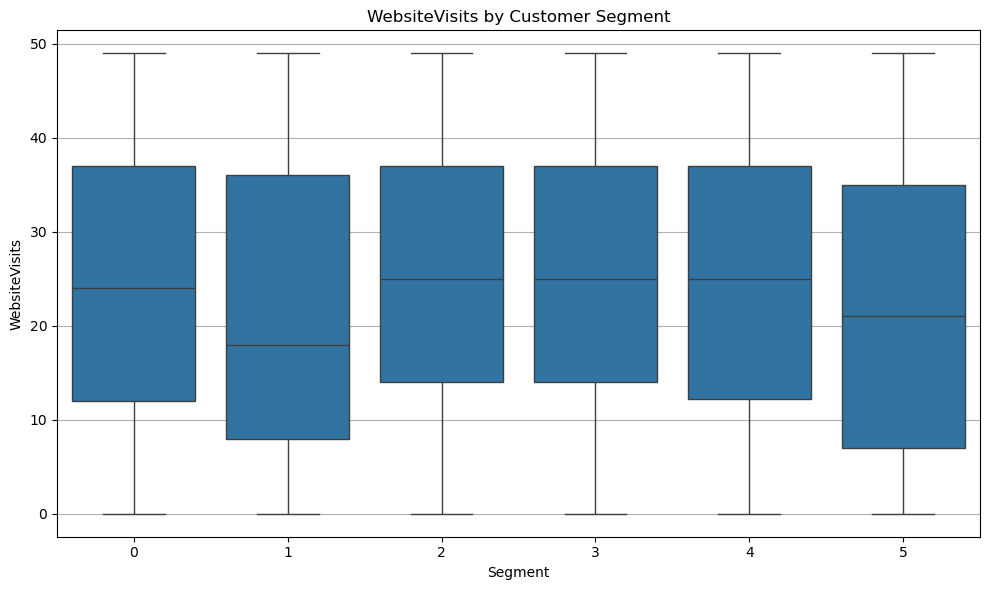

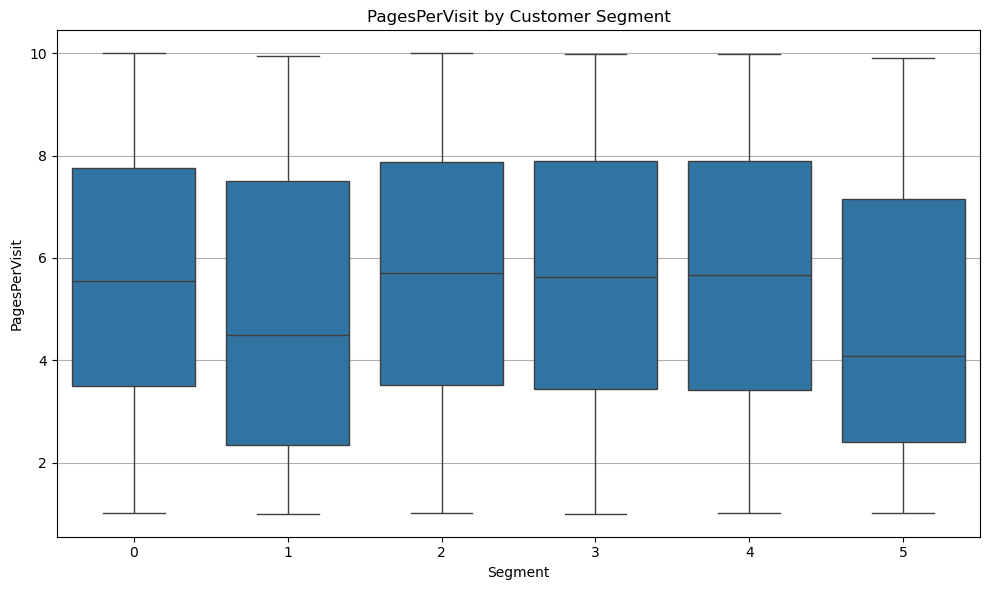

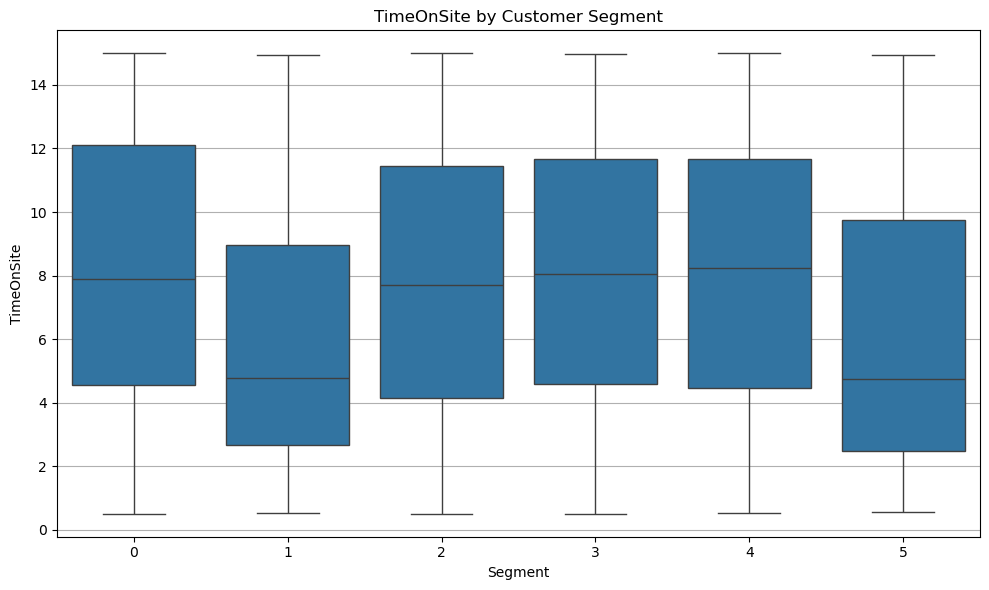

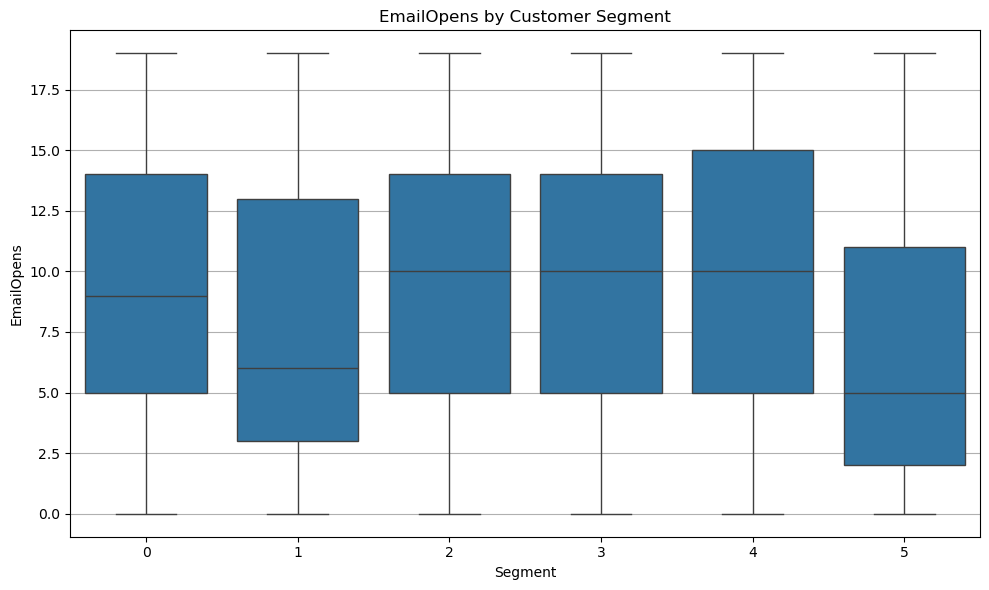

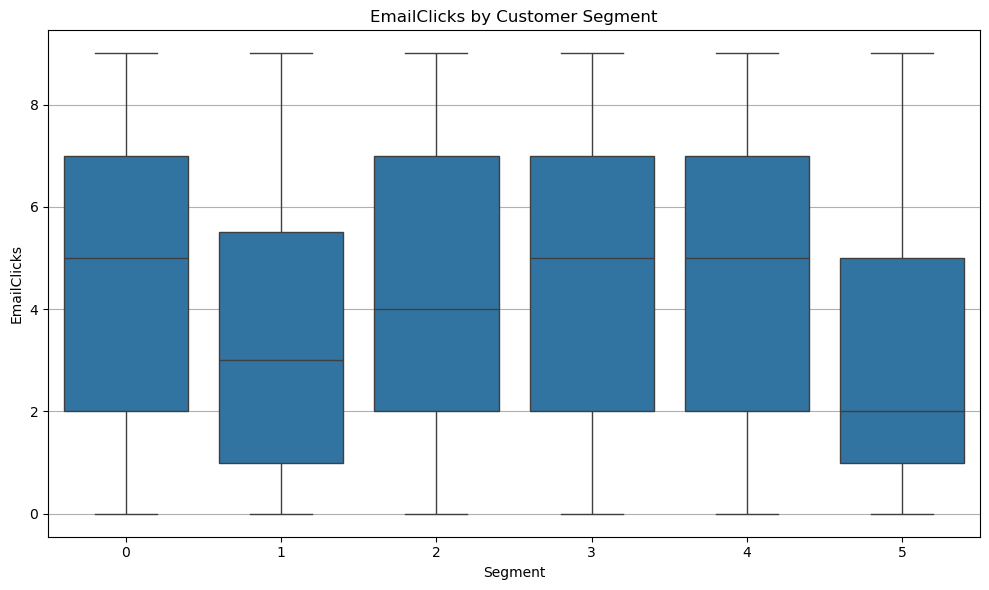

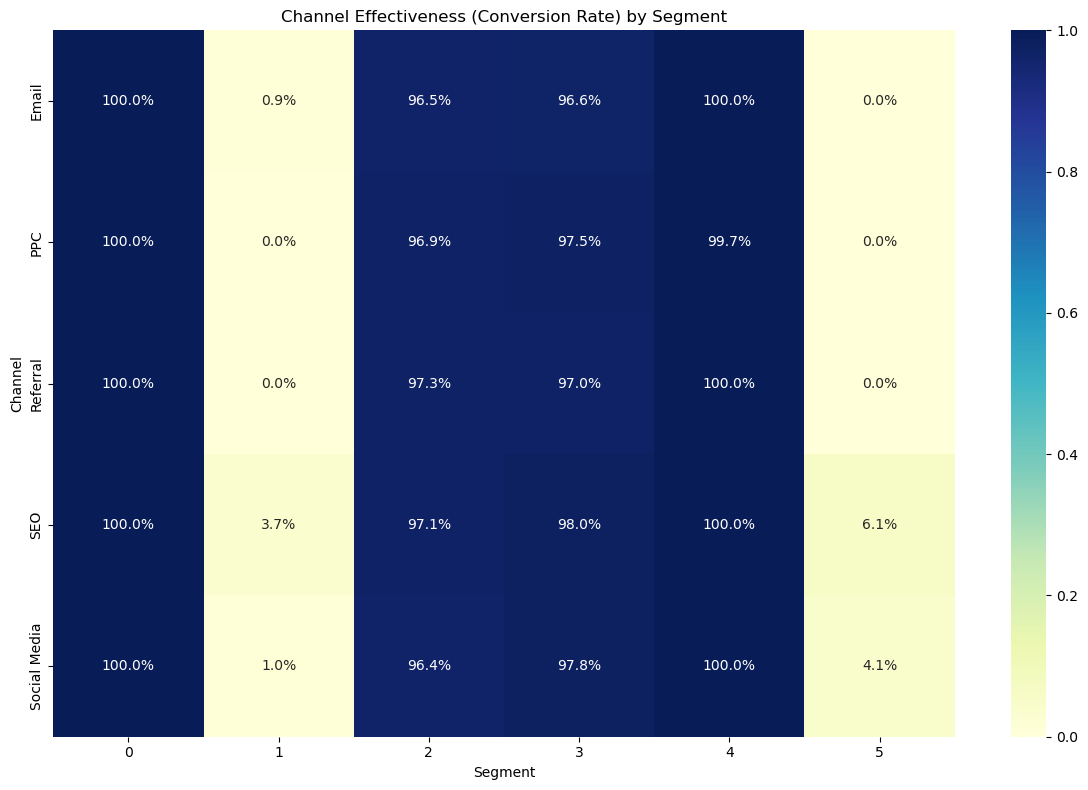

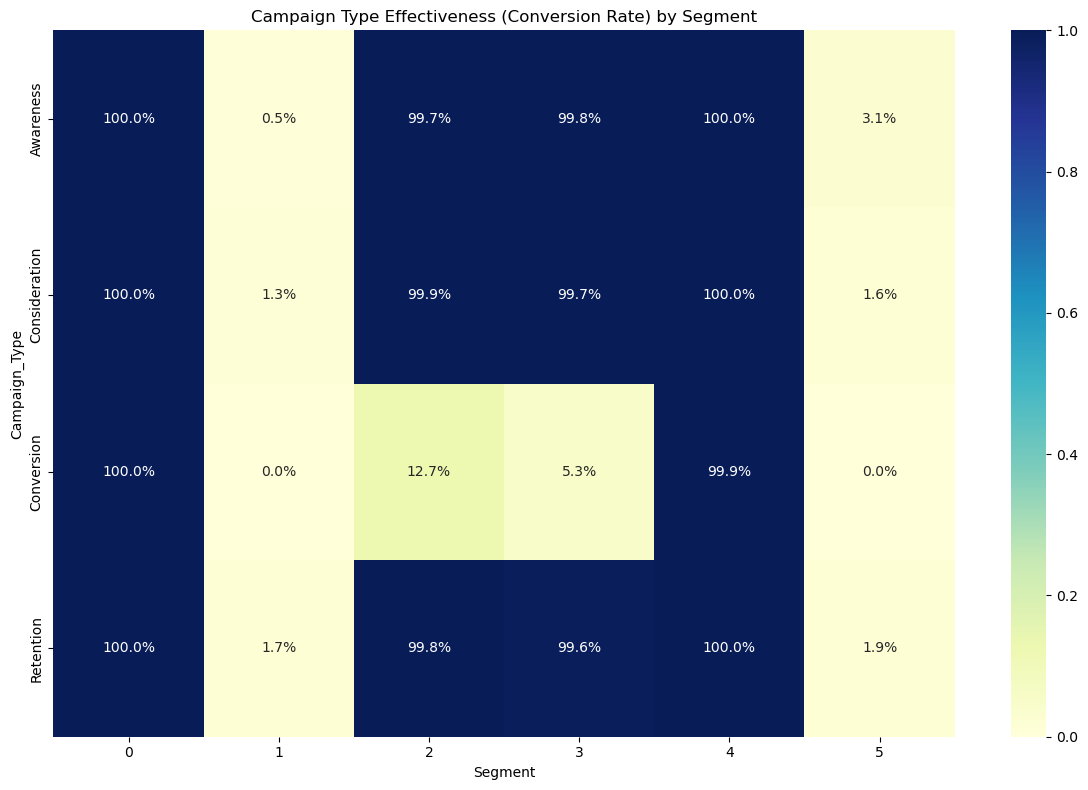

In [119]:
# 2. Behavioral Pattern Identification
# -----------------------------------

# Create function to visualize segment differences for a specific metric
def visualize_segment_differences(df, metric, title):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Cluster_Label', y=metric, data=df)
    plt.title(title)
    plt.xlabel('Segment')
    plt.ylabel(metric)
    plt.grid(axis='y')
    plt.tight_layout()
    # plt.show()

# Analyze key behavioral metrics
for metric in ['WebsiteVisits', 'PagesPerVisit', 'TimeOnSite', 'EmailOpens', 'EmailClicks']:
    visualize_segment_differences(df, metric, f'{metric} by Customer Segment')

# Calculate channel effectiveness by segment
channel_effectiveness = pd.DataFrame(columns=['Segment', 'Channel', 'Conversion_Rate'])

for segment in segments:
    segment_data = df[df['Cluster_Label'] == segment]
    
    for channel in segment_data['CampaignChannel'].unique():
        channel_data = segment_data[segment_data['CampaignChannel'] == channel]
        conversion_rate = channel_data['Conversion'].mean()
        
        channel_effectiveness = pd.concat([
            channel_effectiveness, 
            pd.DataFrame({
                'Segment': [segment],
                'Channel': [channel],
                'Conversion_Rate': [conversion_rate]
            })
        ], ignore_index=True)

# Visualize channel effectiveness
plt.figure(figsize=(12, 8))
channel_pivot = channel_effectiveness.pivot(index='Channel', columns='Segment', values='Conversion_Rate')
sns.heatmap(channel_pivot, annot=True, fmt='.1%', cmap='YlGnBu')
plt.title('Channel Effectiveness (Conversion Rate) by Segment')
plt.tight_layout()
# plt.show()

# Calculate campaign type effectiveness by segment
campaign_effectiveness = pd.DataFrame(columns=['Segment', 'Campaign_Type', 'Conversion_Rate'])

for segment in segments:
    segment_data = df[df['Cluster_Label'] == segment]
    
    for campaign_type in segment_data['CampaignType'].unique():
        campaign_data = segment_data[segment_data['CampaignType'] == campaign_type]
        conversion_rate = campaign_data['Conversion'].mean()
        
        campaign_effectiveness = pd.concat([
            campaign_effectiveness, 
            pd.DataFrame({
                'Segment': [segment],
                'Campaign_Type': [campaign_type],
                'Conversion_Rate': [conversion_rate]
            })
        ], ignore_index=True)

# Visualize campaign type effectiveness
plt.figure(figsize=(12, 8))
campaign_pivot = campaign_effectiveness.pivot(index='Campaign_Type', columns='Segment', values='Conversion_Rate')
sns.heatmap(campaign_pivot, annot=True, fmt='.1%', cmap='YlGnBu')
plt.title('Campaign Type Effectiveness (Conversion Rate) by Segment')
plt.tight_layout()
# plt.show()


In [120]:
# 3. Segment Differentiation Using Feature Importance for Conversion
# -----------------------------------------------------------------

# Prepare data for feature importance analysis
X = df[all_metrics].copy()

# Scale features for better model performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

def segment_conversion_feature_importance(segment):
    """
    Calculate feature importance for conversion prediction within a specific segment.
    Handles segments with 100% conversion rates.
    
    Parameters:
    -----------
    segment : int
        The segment ID to analyze
        
    Returns:
    --------
    pd.DataFrame
        Dataframe with features and their importance scores
    """
    # Filter data for just this segment
    segment_data = df[df['Cluster_Label'] == segment]
    
    # Get features and target for this segment
    X_segment = X_scaled.iloc[segment_data.index]
    y_segment = segment_data['Conversion']
    
    # Check if we have a 100% conversion rate
    if y_segment.mean() == 1.0:
        print(f"Segment {segment} has 100% conversion rate. Using alternative feature analysis.")
        
        # Method 1: Compare to segments with lower conversion
        # Find most distinctive features compared to other segments
        all_other_segments = df[df['Cluster_Label'] != segment]
        
        # Calculate mean differences for each feature
        feature_diff = {}
        for feature in X.columns:
            segment_mean = segment_data[feature].mean()
            others_mean = all_other_segments[feature].mean()
            
            # Calculate percent difference
            if others_mean != 0:
                pct_diff = (segment_mean - others_mean) / others_mean * 100
                feature_diff[feature] = abs(pct_diff)  # Use absolute difference for ranking
        
        # Sort features by their distinctive value
        sorted_features = sorted(feature_diff.items(), key=lambda x: x[1], reverse=True)
        
        # Create DataFrame in same format as feature importance
        feature_imp = pd.DataFrame({
            'Feature': [f[0] for f in sorted_features],
            'Importance': [f[1]/100 for f in sorted_features]  # Normalize to similar scale as feature importance
        })
        
        return feature_imp
    
    # For segments with regular conversion patterns, use the normal approach
    # Train a random forest classifier to predict conversion within this segment
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    
    # Check if we have enough data and both classes represented
    if len(y_segment) < 10 or y_segment.nunique() < 2:
        return pd.DataFrame({
            'Feature': ['Insufficient data'],
            'Importance': [0]
        })
    
    rf.fit(X_segment, y_segment)
    
    # Get feature importances
    importances = rf.feature_importances_
    
    # Create a dataframe with feature importances
    feature_imp = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    return feature_imp







In [121]:

# Calculate conversion feature importance for each segment
segment_conversion_features = {}
for segment in segments:
    segment_conversion_features[segment] = segment_conversion_feature_importance(segment)
    
    print(f"\nTop 5 features driving conversion in Segment {segment}:")
    print(segment_conversion_features[segment].head(5))

Segment 0 has 100% conversion rate. Using alternative feature analysis.

Top 5 features driving conversion in Segment 0:
             Feature  Importance
0        EmailClicks    0.088676
1  PreviousPurchases    0.055805
2         TimeOnSite    0.046623
3     ConversionRate    0.041267
4      LoyaltyPoints    0.040358

Top 5 features driving conversion in Segment 1:
          Feature  Importance
10        AdSpend    0.139225
2      TimeOnSite    0.130988
7   LoyaltyPoints    0.117841
3    SocialShares    0.106291
1   PagesPerVisit    0.084566

Top 5 features driving conversion in Segment 2:
           Feature  Importance
1    PagesPerVisit    0.128127
10         AdSpend    0.123383
9   ConversionRate    0.103280
7    LoyaltyPoints    0.100691
2       TimeOnSite    0.097367

Top 5 features driving conversion in Segment 3:
            Feature  Importance
1     PagesPerVisit    0.130744
7     LoyaltyPoints    0.116622
9    ConversionRate    0.106188
2        TimeOnSite    0.104944
8  Click

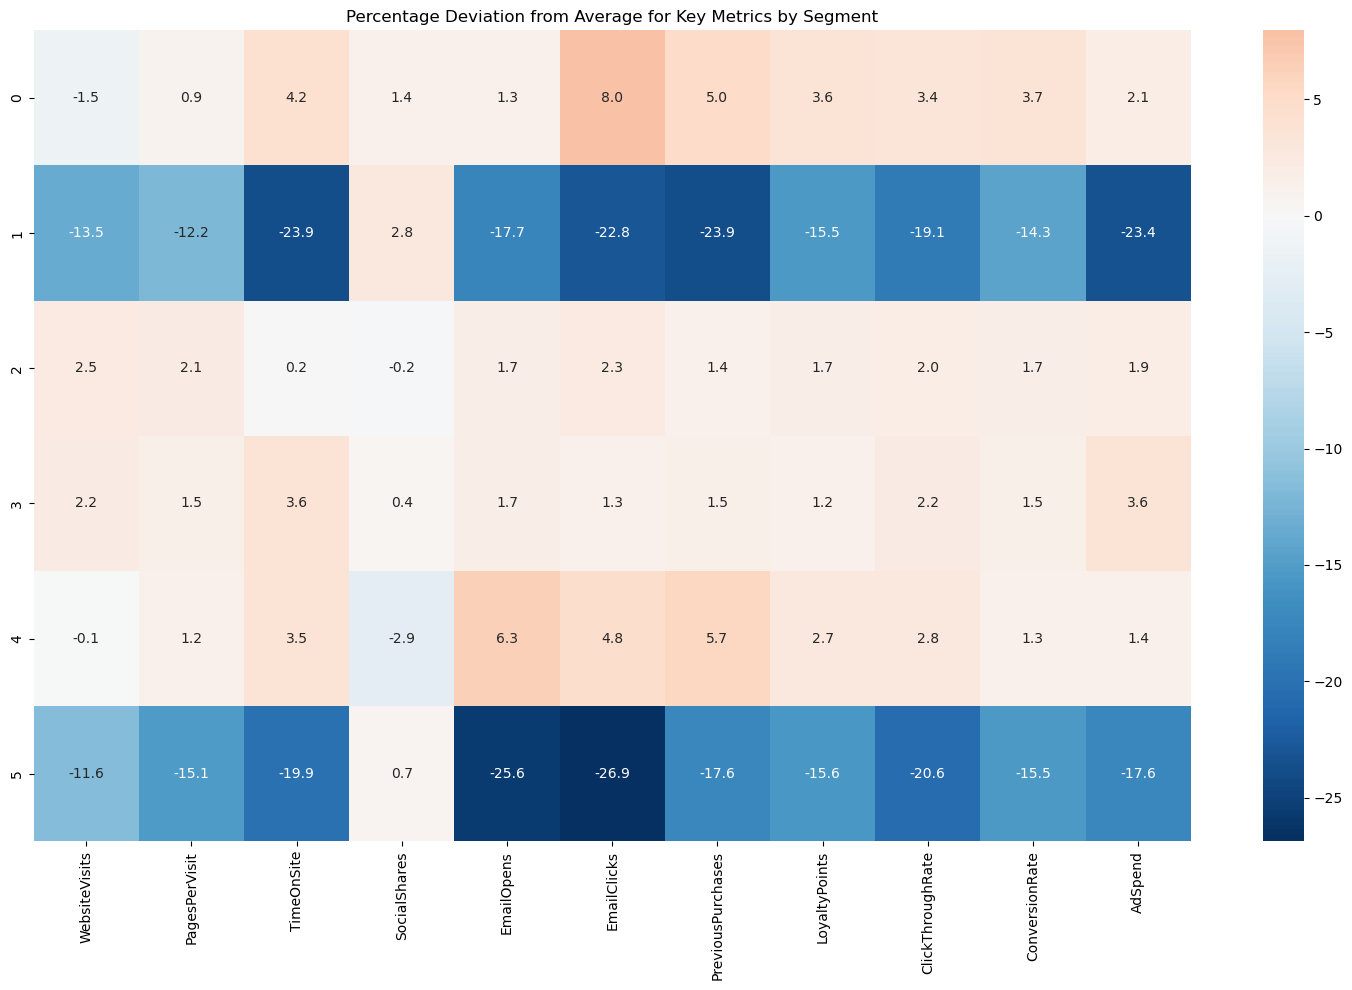

In [122]:
# Analyze how each segment differs from the average for key metrics
# Create a DataFrame with only numeric metrics
numeric_metrics = []
for metric in all_metrics:
    if df[metric].dtype.kind in 'ifc':  # integer, float, or complex
        numeric_metrics.append(metric)

segment_deviations = pd.DataFrame(index=segments, columns=numeric_metrics)

for metric in numeric_metrics:
    overall_avg = df[metric].mean()
    
    for segment in segments:
        segment_avg = df[df['Cluster_Label'] == segment][metric].mean()
        # Avoid division by zero
        if overall_avg != 0:
            percent_diff = (segment_avg - overall_avg) / overall_avg * 100
        else:
            percent_diff = 0 if segment_avg == 0 else 100  # handle division by zero
        segment_deviations.loc[segment, metric] = percent_diff

# Convert all values to float to ensure they're numeric
segment_deviations = segment_deviations.astype(float)

# Visualize segment deviations from average
plt.figure(figsize=(15, 10))
sns.heatmap(segment_deviations, annot=True, fmt='.1f', cmap='RdBu_r', center=0)
plt.title('Percentage Deviation from Average for Key Metrics by Segment')
plt.tight_layout()
# plt.show()

In [123]:
# Combine feature importance with segment deviations to create important traits
important_traits = {}

for segment in segments:
    # Get the top 5 important features for this segment
    segment_features = segment_conversion_features[segment]
    
    # Initialize traits list
    traits = []
    
    # Check if we have valid feature importance data
    if 'Insufficient data' not in segment_features['Feature'].values:
        # Get top 5 important features
        top_features = segment_features.head(5)
        
        for _, row in top_features.iterrows():
            feature = row['Feature']
            importance = row['Importance']
            
            # Check if feature is in our numeric metrics
            if feature in segment_deviations.columns:
                deviation = segment_deviations.loc[segment, feature]
                direction = 'higher' if deviation > 0 else 'lower'
                
                traits.append({
                    'feature': feature,
                    'importance': importance,
                    'deviation': deviation,
                    'direction': direction,
                    'description': f"{abs(deviation):.1f}% {direction} than average"
                })
    
    # Store traits for this segment
    important_traits[segment] = traits

# Determine the best channel and campaign type for each segment
best_channels = {}
best_campaign_types = {}

for segment in segments:
    # Find best channel
    channel_conv = segment_profiles[segment]['channel_preferences']['conversion_rate']
    best_channel = max(channel_conv.items(), key=lambda x: x[1])
    best_channels[segment] = best_channel
    
    # Find best campaign type
    campaign_conv = segment_profiles[segment]['campaign_type_preferences']['conversion_rate']
    best_campaign = max(campaign_conv.items(), key=lambda x: x[1])
    best_campaign_types[segment] = best_campaign

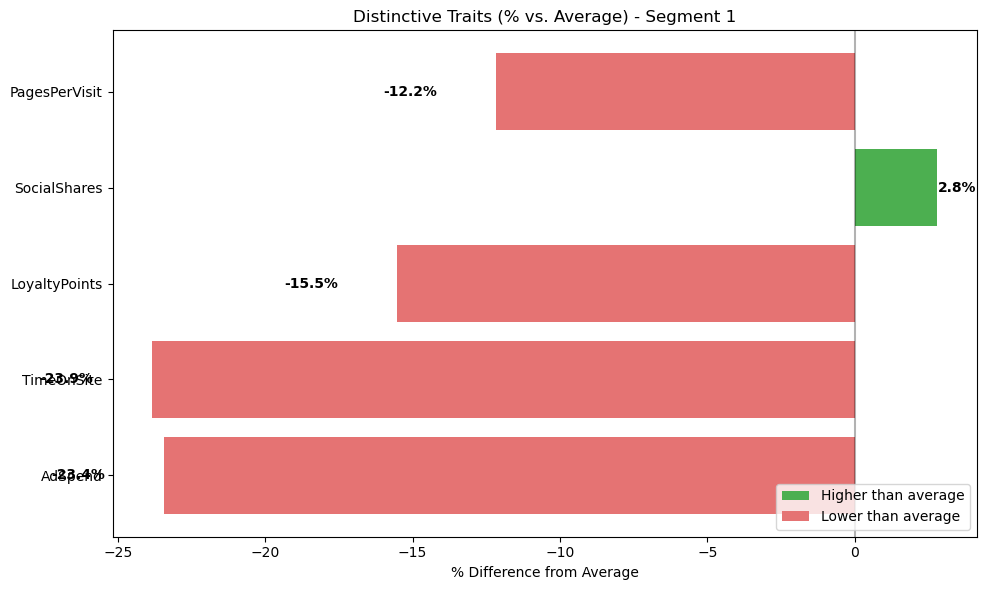

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [124]:
# Function to visualize distinctive traits for a segment
def visualize_distinctive_traits(segment):
    """
    Create a horizontal bar chart of distinctive traits for a segment based on top features.
    
    Parameters:
    -----------
    segment : int
        Segment ID to visualize
    """
    # Get traits for this segment
    traits = important_traits[segment]
    
    # Check if we have traits to visualize
    if not traits:
        print(f"No distinctive traits available for Segment {segment}")
        return
    
    # Extract data for visualization
    features = [t['feature'] for t in traits]
    deviations = [t['deviation'] for t in traits]
    
    # Create figure
    plt.figure(figsize=(10, 6))
    
    # Create bars with appropriate colors
    colors = ['#4CAF50' if dev > 0 else '#E57373' for dev in deviations]
    y_pos = range(len(features))
    
    # Create horizontal bars
    bars = plt.barh(y_pos, deviations, color=colors)
    
    # Add percentage labels to bars
    for i, bar in enumerate(bars):
        width = bar.get_width()
        label_pos = width if width >= 0 else width - 2
        plt.text(label_pos, bar.get_y() + bar.get_height()/2, 
                f"{deviations[i]:.1f}%", 
                ha='left' if width >= 0 else 'right', 
                va='center',
                fontsize=10,
                fontweight='bold')
    
    # Set labels and title
    plt.yticks(y_pos, features)
    plt.xlabel('% Difference from Average')
    plt.title(f'Distinctive Traits (% vs. Average) - Segment {segment}')
    
    # Add a legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#4CAF50', label='Higher than average'),
        Patch(facecolor='#E57373', label='Lower than average')
    ]
    plt.legend(handles=legend_elements, loc='lower right')
    
    # Add vertical line at 0
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    
    # Adjust layout
    plt.tight_layout()
    plt.show()
    
    return plt.gcf()  # Return the figure for saving if needed

# Example: Visualize distinctive traits for segment 0
visualize_distinctive_traits(1)

In [133]:
# Add this code to your script after calculating segment_deviations and before calling the profile cards function

# Make sure we have segment_deviations calculated before calling the function
# (This should already be in your code, but I'm including it for reference)
segment_deviations = pd.DataFrame(index=segments, columns=numeric_metrics)

for metric in numeric_metrics:
    overall_avg = df[metric].mean()
    
    for segment in segments:
        segment_avg = df[df['Cluster_Label'] == segment][metric].mean()
        # Avoid division by zero
        if overall_avg != 0:
            percent_diff = (segment_avg - overall_avg) / overall_avg * 100
        else:
            percent_diff = 0 if segment_avg == 0 else 100  # handle division by zero
        segment_deviations.loc[segment, metric] = percent_diff

# Convert all values to float to ensure they're numeric
segment_deviations = segment_deviations.astype(float)



In [160]:
def create_behavioral_profile_cards(df, segment_profiles, segment_conversion_features, segment_deviations, 
                               best_channels, best_campaign_types, output_dir="profile_cards"):
    """
    Create comprehensive behavioral profile cards for each banking segment
    with improved layout and visual organization
    """
    import os
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec
    import numpy as np
    from matplotlib.patches import Patch
    import matplotlib.patches as mpatches
    from matplotlib.path import Path
    import matplotlib.table as tbl
    import math
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Calculate overall metrics for comparison
    segments = sorted(df['Cluster_Label'].unique())
    segment_conversion_rates = df.groupby('Cluster_Label')['Conversion'].mean() * 100
    
    # Create behavioral profile cards for each segment
    profile_cards = {}
    
    for segment in segments:
        # Create a figure with better proportions for a professional look
        fig = plt.figure(figsize=(12, 9))
        
        # Create a more balanced grid layout
        gs = gridspec.GridSpec(3, 2, figure=fig, height_ratios=[0.6, 1.8, 1.5], width_ratios=[1, 1])
        
        # Get segment data
        profile = segment_profiles[segment]
        segment_size = profile['size']
        segment_size_pct = profile['size_percentage']
        segment_conversion_rate = segment_conversion_rates[segment]
        
        # Define a color scheme for banking
        main_color = '#1E5C97'  # Banking blue
        secondary_color = '#78A2CC'  # Lighter blue
        positive_color = '#4CAF50'  # Green for positive values
        negative_color = '#E57373'  # Red for negative values
        
        # Add a border to the entire figure
        fig.patch.set_edgecolor(main_color)
        fig.patch.set_linewidth(1)
        
        #----- HEADER SECTION -----#
        ax_header = fig.add_subplot(gs[0, :])
        ax_header.axis('off')
        ax_header.text(0.5, 0.6, f"Banking Segment {segment} Profile", 
                      fontsize=22, weight='bold', ha='center', color=main_color)
        ax_header.text(0.5, 0.2, 
                      f"Size: {segment_size} customers ({segment_size_pct:.1f}%)", 
                      fontsize=14, ha='center')
        
        #----- TOP FEATURES WITH DEVIATION COMPARISON -----#
        ax_features = fig.add_subplot(gs[1, 0])
        ax_features.axis('off')
        ax_features.text(0.5, 1.05, "Top Features Driving Conversion", 
                       fontsize=16, weight='bold', ha='center')
        ax_features.text(0.5, 0.97, "Comparison to Average", 
                       fontsize=14, ha='center')
        
        # Get top 5 features for this segment
        if 'Insufficient data' not in segment_conversion_features[segment]['Feature'].values:
            # Get top 5 features by importance
            top_features = segment_conversion_features[segment].head(5)
            features = top_features['Feature'].values
            importance = top_features['Importance'].values  # We'll use this for sorting but not display
            
            # Get deviations for these features
            deviations = []
            for feature in features:
                if feature in segment_deviations.columns:
                    deviations.append(segment_deviations.loc[segment, feature])
                else:
                    deviations.append(0)  # Default if not found
            
            # Sort by importance (highest first)
            sorted_indices = np.argsort(importance)[::-1]
            features = [features[i] for i in sorted_indices]
            deviations = [deviations[i] for i in sorted_indices]
            
            # Position for bars
            y_pos = np.arange(len(features))
            bar_height = 0.5
            
            # Create horizontal bars for deviations
            for i, (feature, deviation) in enumerate(zip(features, deviations)):
                # Color based on whether higher or lower than average
                color = positive_color if deviation > 0 else negative_color
                
                # Create the horizontal bar
                ax_features.barh(y_pos[i], deviation, height=bar_height, color=color, alpha=0.8)
                
                # Feature label on y-axis - cleaner layout with better alignment
                ax_features.text(-5, y_pos[i], feature, va='center', ha='right', 
                               fontsize=12, fontweight='bold')
                
                # Add percentage labels - more consistent positioning
                label_pos = deviation + (1 if deviation >= 0 else -1)
                ax_features.text(label_pos, y_pos[i], f"{deviation:.1f}% vs. avg", 
                               va='center', ha='left' if deviation >= 0 else 'right',
                               fontsize=11, fontweight='bold')
                
            # Set axis limits with better proportions
            max_dev = max([abs(d) for d in deviations]) * 1.2
            ax_features.set_xlim(-max_dev, max_dev)
            
            # Add extra space for labels
            ax_features.set_ylim(-0.5, len(features)-0.5)
            
            # Remove y-ticks (we have text labels)
            ax_features.set_yticks([])
            
            # Add a vertical line at 0 - cleaner line style
            ax_features.axvline(x=0, color='gray', linestyle='-', alpha=0.5, linewidth=1)
            
            # Add legend with better positioning and clearer labels
            legend_elements = [
                Patch(facecolor=positive_color, label='Higher than average', alpha=0.8),
                Patch(facecolor=negative_color, label='Lower than average', alpha=0.8)
            ]
            ax_features.legend(handles=legend_elements, loc='lower center', fontsize=10, 
                             frameon=True, framealpha=0.9, edgecolor='lightgray')
            
            # Add explanatory note - simpler text
            ax_features.text(0.5, -0.15, 
                           "Shows how top conversion-driving features compare to average", 
                           fontsize=9, style='italic', ha='center', transform=ax_features.transAxes)
        else:
            ax_features.text(0.5, 0.5, "Insufficient data for feature importance", 
                           ha='center', fontsize=12, style='italic')
            
        #----- DIGITAL ENGAGEMENT PROFILE (RADAR CHART) -----#
        ax_engagement = fig.add_subplot(gs[1, 1], polar=True)
        
        # Get engagement metrics for radar chart
        engagement = profile['digital_engagement']
        
        # Define the metrics to display in the radar chart - ordered for better visual flow
        radar_metrics = [
            'Website Visits', 
            'Pages/Visit', 
            'Time on Site', 
            'Email CTR', 
            'Engagement Depth', 
            'Social Propensity'
        ]
        
        # Get values for these metrics
        radar_values = [
            engagement['WebsiteVisits'],
            engagement['PagesPerVisit'],
            engagement['TimeOnSite'],
            engagement['email_ctr'],
            engagement['engagement_depth'],
            engagement['social_propensity']
        ]
        
        # Normalize values between 0 and 1 for the radar chart
        # Get max values for each metric across all segments for normalization
        max_values = {}
        for s in segments:
            s_profile = segment_profiles[s]
            s_engagement = s_profile['digital_engagement']
            
            max_values['WebsiteVisits'] = max(max_values.get('WebsiteVisits', 0), s_engagement['WebsiteVisits'])
            max_values['PagesPerVisit'] = max(max_values.get('PagesPerVisit', 0), s_engagement['PagesPerVisit'])
            max_values['TimeOnSite'] = max(max_values.get('TimeOnSite', 0), s_engagement['TimeOnSite'])
            max_values['email_ctr'] = max(max_values.get('email_ctr', 0), s_engagement['email_ctr'])
            max_values['engagement_depth'] = max(max_values.get('engagement_depth', 0), s_engagement['engagement_depth'])
            max_values['social_propensity'] = max(max_values.get('social_propensity', 0), s_engagement['social_propensity'])
        
        # Ensure we don't divide by zero
        for key, value in max_values.items():
            if value == 0:
                max_values[key] = 1
        
        # Normalize the values
        normalized_values = [
            radar_values[0] / max_values['WebsiteVisits'],
            radar_values[1] / max_values['PagesPerVisit'],
            radar_values[2] / max_values['TimeOnSite'],
            radar_values[3] / max_values['email_ctr'],
            radar_values[4] / max_values['engagement_depth'],
            radar_values[5] / max_values['social_propensity']
        ]
        
        # Add the first value again to close the polygon
        radar_metrics = np.append(radar_metrics, radar_metrics[0])
        normalized_values = np.append(normalized_values, normalized_values[0])
        
        # Compute angle for each metric (in radians)
        angles = np.linspace(0, 2*np.pi, len(radar_metrics)-1, endpoint=False)
        angles = np.append(angles, angles[0])  # Close the loop
        
        # Draw the radar chart - improved styling
        ax_engagement.plot(angles, normalized_values, 'o-', linewidth=2, color=main_color)
        ax_engagement.fill(angles, normalized_values, alpha=0.25, color=main_color)
        
        # Set the labels with better font size and weight
        ax_engagement.set_thetagrids(angles * 180/np.pi, radar_metrics, fontsize=10)
        
        # Draw concentric circles with better styling
        ax_engagement.set_ylim(0, 1)
        ax_engagement.grid(True, alpha=0.3)
        
        circles = [0.2, 0.4, 0.6, 0.8, 1.0]
        for circle in circles:
            ax_engagement.text(np.pi/2, circle, str(circle), ha='center', va='bottom', 
                             color='gray', alpha=0.7, fontsize=8)
        
        # Remove the radial labels (they're not needed)
        ax_engagement.set_yticklabels([])
        
        # Add actual values next to points - improved label design
        for i, value in enumerate(radar_values[:-1]):  # Skip the last one which is a duplicate
            angle = angles[i]
            norm_val = normalized_values[i]
            
            # Calculate the x, y position for the label - improved positioning
            x = norm_val * np.cos(angle)
            y = norm_val * np.sin(angle)
            
            # Format the value appropriately
            if i == 3:  # Email CTR as percentage
                val_str = f"{value*100:.1f}%"
            elif i == 5:  # Social propensity with 2 decimals
                val_str = f"{value:.2f}"
            else:  # Others with 1 decimal
                val_str = f"{value:.1f}"
            
            # Add value label with better styling
            if norm_val > 0.1:  # Only add label if there's space
                ax_engagement.annotate(val_str, xy=(angle, norm_val), xytext=(x*1.3, y*1.3),
                                     textcoords='data', ha='center', va='center',
                                     bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="lightgray", alpha=0.9),
                                     fontsize=9)
        
        # Set the title with better positioning
        plt.figtext(0.75, 0.72, "Digital Engagement Profile", fontsize=16, weight='bold', ha='center')
        
        #----- VALUE METRICS SECTION (TABLE) -----#
        ax_value = fig.add_subplot(gs[2, 0])
        ax_value.axis('off')
        
        # Add a clear section title
        ax_value.text(0.5, 1.1, "Value Metrics", fontsize=16, weight='bold', ha='center')
        
        # Create a table with better styling
        value_data = [
            ['Metric', 'Value'],
            ['Conversion Rate', f"{segment_conversion_rate:.1f}%"],
            ['Previous Purchases', f"{profile['transaction_history']['PreviousPurchases']:.1f}"],
            ['Loyalty Points', f"{profile['transaction_history']['LoyaltyPoints']:.0f}"]
        ]
        
        # Create the table with improved positioning and proportions
        table = ax_value.table(
            cellText=value_data,
            loc='center',
            cellLoc='center',
            colWidths=[0.5, 0.3],
            bbox=[0.15, 0.15, 0.7, 0.7]  # Better positioning
        )
        
        # Style the table more professionally
        table.auto_set_font_size(False)
        table.set_fontsize(12)
        table.scale(1, 1.5)  # Better height-to-width ratio
        
        # Style header row
        for j in range(2):
            table[(0, j)].set_facecolor('#EBF1F6')
            table[(0, j)].set_text_props(weight='bold')
        
        # Style data cells
        for i in range(1, len(value_data)):
            for j in range(2):
                if j == 0:  # Left column (metric names)
                    table[(i, j)].set_text_props(ha='left', weight='bold')
                else:  # Right column (values)
                    table[(i, j)].set_text_props(ha='right')
        
        #----- CHANNEL & CAMPAIGN PREFERENCES SECTION -----#
        ax_pref = fig.add_subplot(gs[2, 1])
        ax_pref.axis('off')
        
        # Create a more organized layout with two clear columns
        
        # Left side - Channel Preferences
        ax_pref.text(0.25, 1.1, "Channel Preferences", fontsize=16, weight='bold', ha='center')
        
        # Best channel info with better formatting
        best_channel, best_channel_conv = best_channels[segment]
        ax_pref.text(0.05, 0.85, "Best Channel:", fontsize=12, weight='bold')
        ax_pref.text(0.35, 0.85, f"{best_channel}", fontsize=12, color=main_color, weight='bold')
        ax_pref.text(0.35, 0.78, f"Conversion: {best_channel_conv*100:.1f}%", fontsize=10)
        
        # Channel distribution with cleaner layout
        ax_pref.text(0.05, 0.68, "Channel Distribution:", fontsize=11, weight='bold')
        
        channel_dist = profile['channel_preferences']['distribution']
        sorted_channels = sorted(channel_dist.items(), key=lambda x: x[1], reverse=True)
        
        for i, (channel, percentage) in enumerate(sorted_channels):
            if i < 4:  # Show top 4 channels
                ax_pref.text(0.05, 0.6 - i*0.09, f"{channel}", fontsize=10)
                ax_pref.text(0.4, 0.6 - i*0.09, f"{percentage:.1f}%", fontsize=10, ha='right')
        
        # Right side - Campaign Preferences
        ax_pref.text(0.75, 1.1, "Campaign Preferences", fontsize=16, weight='bold', ha='center')
        
        # Best campaign info with better formatting
        best_campaign, best_campaign_conv = best_campaign_types[segment]
        ax_pref.text(0.55, 0.85, "Best Campaign Type:", fontsize=12, weight='bold')
        ax_pref.text(0.85, 0.85, f"{best_campaign}", fontsize=12, color=main_color, weight='bold')
        ax_pref.text(0.85, 0.78, f"Conversion: {best_campaign_conv*100:.1f}%", fontsize=10)
        
        # Campaign distribution with cleaner layout
        ax_pref.text(0.55, 0.68, "Campaign Distribution:", fontsize=11, weight='bold')
        
        campaign_dist = profile['campaign_type_preferences']['distribution']
        sorted_campaigns = sorted(campaign_dist.items(), key=lambda x: x[1], reverse=True)
        
        for i, (campaign, percentage) in enumerate(sorted_campaigns):
            if i < 4:  # Show top 4 campaign types
                ax_pref.text(0.55, 0.6 - i*0.09, f"{campaign}", fontsize=10)
                ax_pref.text(0.9, 0.6 - i*0.09, f"{percentage:.1f}%", fontsize=10, ha='right')
        
        # Add a subtle divider line between the two columns
        ax_pref.axvline(x=0.5, ymin=0, ymax=0.9, color='lightgray', linewidth=1, alpha=0.7)
        
        # Improve overall layout
        plt.tight_layout(pad=1.0)
        plt.subplots_adjust(wspace=0.1, hspace=0.2)
        
        # Save the profile card with high quality
        fig.savefig(f"{output_dir}/segment_{segment}_profile_card.png", dpi=300, bbox_inches='tight')
        plt.close(fig)
        
        # Store profile card data in dictionary (unchanged)
        profile_cards[segment] = {
            'segment_id': segment,
            'size': {
                'count': segment_size,
                'percentage': f"{segment_size_pct:.1f}%"
            },
            'top_features': [
                {
                    'feature': feat,
                    'deviation': dev,
                    'direction': 'higher' if dev > 0 else 'lower'
                }
                for feat, dev in zip(features, deviations)
            ] if 'Insufficient data' not in segment_conversion_features[segment]['Feature'].values else [],
            'engagement_patterns': {
                'website_visits': f"{profile['digital_engagement']['WebsiteVisits']:.1f}",
                'pages_per_visit': f"{profile['digital_engagement']['PagesPerVisit']:.1f}",
                'time_on_site': f"{profile['digital_engagement']['TimeOnSite']:.1f} min",
                'email_ctr': f"{profile['digital_engagement']['email_ctr']*100:.1f}%",
                'engagement_depth': f"{profile['digital_engagement']['engagement_depth']:.1f}",
                'social_propensity': f"{profile['digital_engagement']['social_propensity']:.2f}"
            },
            'value_metrics': {
                'conversion_rate': f"{segment_conversion_rate:.1f}%",
                'previous_purchases': f"{profile['transaction_history']['PreviousPurchases']:.1f}",
                'loyalty_points': f"{profile['transaction_history']['LoyaltyPoints']:.0f}"
            },
            'channel_preferences': {
                'best_channel': best_channel,
                'best_channel_conversion': f"{best_channel_conv*100:.1f}%",
                'distribution': channel_dist
            },
            'campaign_preferences': {
                'best_campaign': best_campaign,
                'best_campaign_conversion': f"{best_campaign_conv*100:.1f}%",
                'distribution': campaign_dist
            }
        }
    
    print(f"Created profile cards for {len(segments)} segments in '{output_dir}' directory")
    return profile_cards

In [161]:
def display_segment_profile_card(segment, profile_cards, output_dir="profile_cards"):
    """
    Display a profile card for a specific segment and print key insights
    
    Parameters:
    -----------
    segment : int
        The segment ID to display
    profile_cards : dict
        Dictionary containing profile card data from create_behavioral_profile_cards()
    output_dir : str, optional
        Directory where profile cards are saved
    """
    from IPython.display import Image, display
    import os
    
    file_path = f"{output_dir}/segment_{segment}_profile_card.png"
    
    if os.path.exists(file_path):
        print(f"Profile Card for Segment {segment}:")
        display(Image(filename=file_path))
        
        # Print key insights for this segment
        if segment in profile_cards:
            card = profile_cards[segment]
            
            print(f"\nSegment Size: {card['size']['count']} customers ({card['size']['percentage']})")
            print(f"Conversion Rate: {card['value_metrics']['conversion_rate']}")
            
            print("\nTop Features and Comparison to Average:")
            if 'top_features' in card and card['top_features']:
                for i, feature in enumerate(card['top_features'], 1):
                    feat_name = feature['feature']
                    deviation = feature['deviation']
                    direction = feature['direction']
                    
                    print(f"  {i}. {feat_name}: {abs(deviation):.1f}% {direction} than average")
            else:
                print("  Insufficient data for feature analysis")
            
            print(f"\nBest Channel: {card['channel_preferences']['best_channel']} " +
                 f"(Conversion: {card['channel_preferences']['best_channel_conversion']})")
            
            print(f"Best Campaign: {card['campaign_preferences']['best_campaign']} " +
                 f"(Conversion: {card['campaign_preferences']['best_campaign_conversion']})")
    else:
        print(f"Profile card for Segment {segment} not found at {file_path}")
        print(f"Please make sure you've created profile cards using create_behavioral_profile_cards() function")

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


Created profile cards for 6 segments in 'profile_cards' directory
Profile Card for Segment 0:


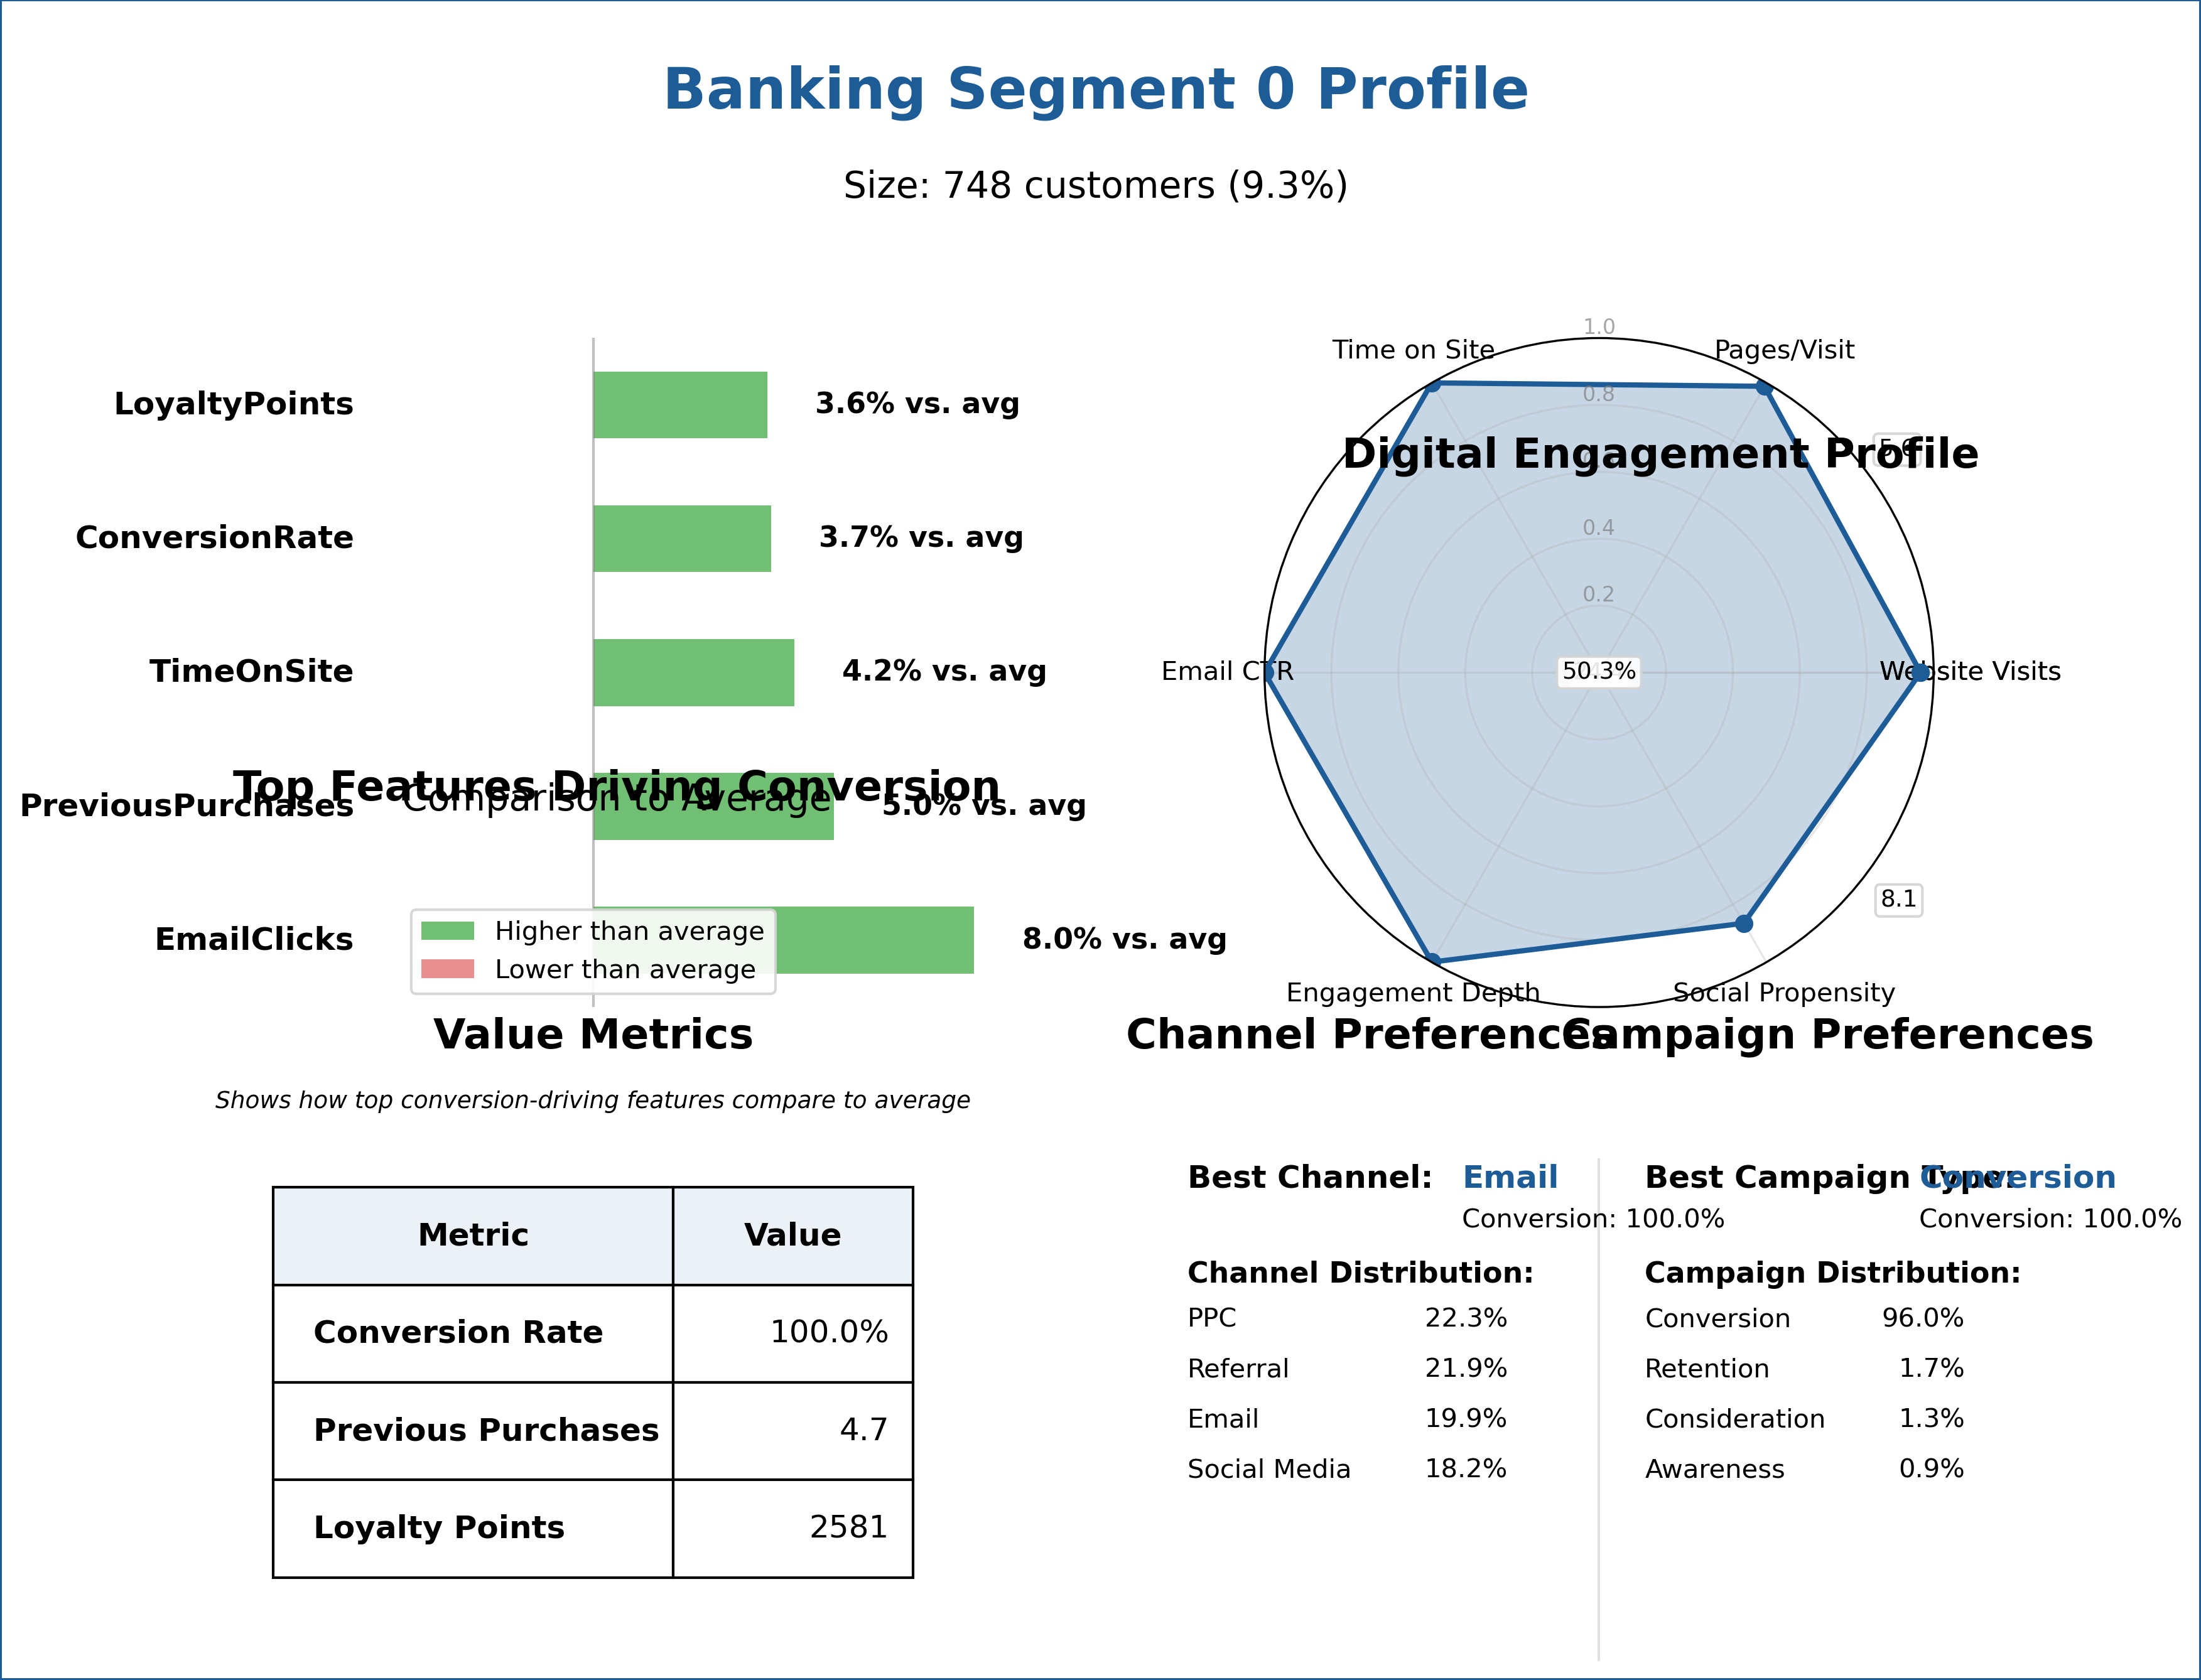


Segment Size: 748 customers (9.3%)
Conversion Rate: 100.0%

Top Features and Comparison to Average:
  1. EmailClicks: 8.0% higher than average
  2. PreviousPurchases: 5.0% higher than average
  3. TimeOnSite: 4.2% higher than average
  4. ConversionRate: 3.7% higher than average
  5. LoyaltyPoints: 3.6% higher than average

Best Channel: Email (Conversion: 100.0%)
Best Campaign: Conversion (Conversion: 100.0%)


In [162]:
# Execute the code to create and display the profile card
# Create the output directory
output_dir = "profile_cards"
os.makedirs(output_dir, exist_ok=True)

# Create profile cards for all segments
profile_cards = create_behavioral_profile_cards(df, segment_profiles, segment_conversion_features, 
                                             segment_deviations, best_channels, best_campaign_types,
                                             output_dir=output_dir)

# Display profile card for segment 0
display_segment_profile_card(0, profile_cards, output_dir=output_dir)